In [1]:
!pip install ltn
!pip install ltn[examples]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ltn

2024-06-26 08:30:36.992694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 08:30:36.992827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 08:30:37.154043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Configuration
np.set_printoptions(suppress=True)
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.2f}'.format

def plt_heatmap(df, vmin=None, vmax=None):
    plt.pcolor(df, vmin=vmin, vmax=vmax)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.colorbar()

In [4]:
# Constants and Grounding
embedding_size = 5
prisoners = {p: ltn.Constant(np.random.uniform(low=0.0, high=1.0, size=embedding_size), trainable=True) for p in 'abcdefgh'}

# Predicates
Cooperate = ltn.Predicate.MLP([embedding_size], hidden_layer_sizes=(8, 8))
Betray = ltn.Predicate.MLP([embedding_size], hidden_layer_sizes=(8, 8))
Payoff = ltn.Predicate.MLP([embedding_size], hidden_layer_sizes=(8, 8))

# Data
cooperate = ['a', 'b', 'e', 'h']
betray = ['c', 'd', 'f', 'g']
payoff_high = ['a', 'c']
payoff_low = ['b', 'd', 'e', 'f', 'g', 'h']

# Connectives and Quantifiers
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2), semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6), semantics="exists")
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError())

In [5]:
# Theory Axioms
@tf.function
def axioms(p_exists):
    p = ltn.Variable.from_constants("p", list(prisoners.values()))
    q = ltn.Variable.from_constants("q", list(prisoners.values()))
    axioms = []

    # Cooperation and Betrayal knowledge
    axioms.append(formula_aggregator([Cooperate(prisoners[p]) for p in cooperate]))
    axioms.append(formula_aggregator([Betray(prisoners[p]) for p in betray]))
    axioms.append(formula_aggregator([Not(Cooperate(prisoners[p])) for p in prisoners if p not in cooperate]))
    axioms.append(formula_aggregator([Not(Betray(prisoners[p])) for p in prisoners if p not in betray]))

    # Payoff knowledge
    axioms.append(formula_aggregator([Payoff(prisoners[p]) for p in payoff_high]))
    axioms.append(formula_aggregator([Not(Payoff(prisoners[p])) for p in payoff_low]))

    # Logic of the dilemma
    axioms.append(Forall(p, Implies(Cooperate(p), Not(Betray(p)))))
    axioms.append(Forall(p, Implies(Betray(p), Not(Cooperate(p)))))
    axioms.append(Forall(p, Implies(Cooperate(p), Payoff(p))))
    axioms.append(Forall(p, Implies(Not(Cooperate(p)), Not(Payoff(p)))))

    # Everyone chooses an action
    axioms.append(Forall(p, Or(Cooperate(p), Betray(p))))

    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [6]:
# Training
trainable_variables = Cooperate.trainable_variables + Betray.trainable_variables + Payoff.trainable_variables + ltn.as_tensors(list(prisoners.values()))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(2000):
    if 0 <= epoch < 400:
        p_exists = tf.constant(1.)
    else:
        p_exists = tf.constant(6.)
    with tf.GradientTape() as tape:
        loss_value = 1. - axioms(p_exists=p_exists)
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch % 200 == 0:
        print("Epoch %d: Sat Level %.3f" % (epoch, axioms(p_exists=p_exists)))
print("Training finished at Epoch %d with Sat Level %.3f" % (epoch, axioms(p_exists=p_exists)))


/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: No instance of <class 'tensorflow.python.eager.backprop.GradientTape'> passed in argument when creating a LTN variable from constants. LTN cannot verify that a tape is recording. If you created the variable within the scope of a tape, or that you don't need to track weights (e.g. non-trainable constants), you can ignore this warning.
  return py_builtins.overload_of(f)(*args)


Epoch 0: Sat Level 0.605
Epoch 200: Sat Level 0.824
Epoch 400: Sat Level 0.837
Epoch 600: Sat Level 0.838
Epoch 800: Sat Level 0.838
Epoch 1000: Sat Level 0.838
Epoch 1200: Sat Level 0.838
Epoch 1400: Sat Level 0.838
Epoch 1600: Sat Level 0.838
Epoch 1800: Sat Level 0.838
Training finished at Epoch 1999 with Sat Level 0.838


In [8]:
# Results
df_cooperate_betray_facts = pd.DataFrame(
    np.array([[(x in cooperate), (x in betray)] for x in prisoners]),
    columns=["Cooperate", "Betray"],
    index=list('abcdefgh')
)
df_payoff_facts = pd.DataFrame(
    np.array([[(x in payoff_high), (x in payoff_low)] for x in prisoners]),
    columns=["Payoff High", "Payoff Low"],
    index=list('abcdefgh')
)

p = ltn.Variable.from_constants("p", list(prisoners.values()))
df_cooperate_betray = pd.DataFrame(
    tf.stack([Cooperate(p).tensor, Betray(p).tensor], axis=1).numpy(),
    columns=["Cooperate", "Betray"],
    index=list('abcdefgh')
)
df_payoff = pd.DataFrame(
    Payoff(p).tensor.numpy(),
    columns=["Payoff"],
    index=list('abcdefgh')
)

/opt/conda/lib/python3.10/site-packages/ltn/core.py:85: UserWarning: No instance of <class 'tensorflow.python.eager.backprop.GradientTape'> passed in argument when creating a LTN variable from constants. LTN cannot verify that a tape is recording. If you created the variable within the scope of a tape, or that you don't need to track weights (e.g. non-trainable constants), you can ignore this warning.
  warnings.warn("No instance of %s passed in argument when creating a LTN variable from constants. "\


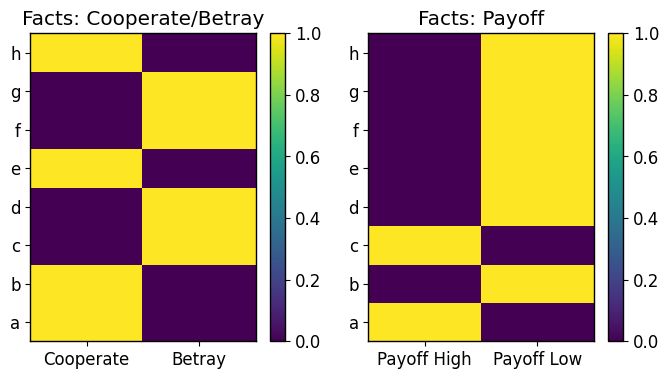

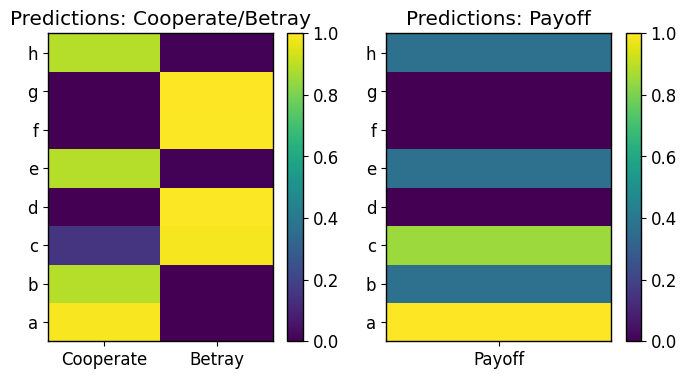

In [9]:
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

# Visualize Facts
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Facts: Cooperate/Betray")
plt_heatmap(df_cooperate_betray_facts, vmin=0, vmax=1)

plt.subplot(122)
plt.title("Facts: Payoff")
plt_heatmap(df_payoff_facts, vmin=0, vmax=1)
plt.show()

# Visualize Predictions
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Predictions: Cooperate/Betray")
plt_heatmap(df_cooperate_betray, vmin=0, vmax=1)

plt.subplot(122)
plt.title("Predictions: Payoff")
plt_heatmap(df_payoff, vmin=0, vmax=1)
plt.show()

forall p: Cooperate(p) -> ~Betray(p) : 0.95
forall p: Betray(p) -> ~Cooperate(p) : 0.95
forall p: Cooperate(p) -> Payoff(p) : 0.66
forall p: ~Cooperate(p) -> ~Payoff(p) : 0.74
forall p: Cooperate(p) or Betray(p) : 0.93


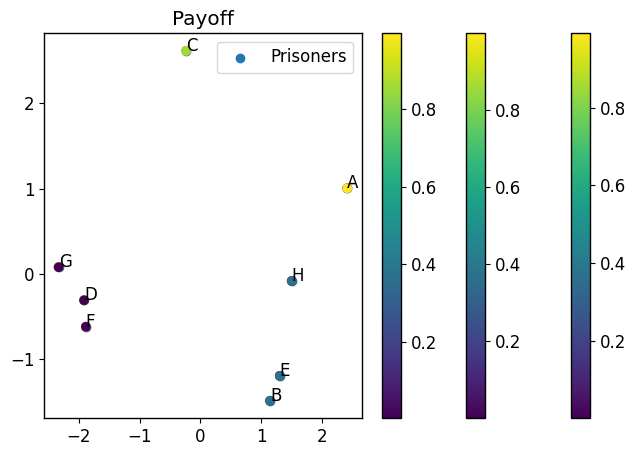

In [10]:
# Satisfiability of the axioms
print("forall p: Cooperate(p) -> ~Betray(p) : %.2f" % Forall(p, Implies(Cooperate(p), Not(Betray(p)))).tensor)
print("forall p: Betray(p) -> ~Cooperate(p) : %.2f" % Forall(p, Implies(Betray(p), Not(Cooperate(p)))).tensor)
print("forall p: Cooperate(p) -> Payoff(p) : %.2f" % Forall(p, Implies(Cooperate(p), Payoff(p))).tensor)
print("forall p: ~Cooperate(p) -> ~Payoff(p) : %.2f" % Forall(p, Implies(Not(Cooperate(p)), Not(Payoff(p)))).tensor)
print("forall p: Cooperate(p) or Betray(p) : %.2f" % Forall(p, Or(Cooperate(p), Betray(p))).tensor)

# Visualize the embeddings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = [c.tensor.numpy() for c in prisoners.values()]
x_norm = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x_norm)
var_x = ltn.Variable("x", x)

plt.figure(figsize=(8, 5))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], label="Prisoners")
names = list(prisoners.keys())
for i in range(len(names)):
    plt.annotate(names[i].upper(), pca_transformed[i])
plt.title("Embeddings")
plt.legend()

plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=Cooperate(var_x).tensor)
plt.title("Cooperate")
plt.colorbar()

plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=Betray(var_x).tensor)
plt.title("Betray")
plt.colorbar()

plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=Payoff(var_x).tensor)
plt.title("Payoff")
plt.colorbar()

plt.show()
